# 该作业基于课程发布的作业样例修改而成，感谢老师和助教的辛勤付出！

# **Homework 1: Linear Regression**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->


若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# **Load data**


In [ ]:
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive 
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip
!unzip data.zip
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')

Downloading...
From: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
To: /content/data.zip
100% 177k/177k [00:00<00:00, 54.2MB/s]
Archive:  data.zip
  inflating: test.csv                
  inflating: train.csv               


# **Data Process**
**将所有数据处理的部分打包成一个函数，最后返回dataset**

train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

# **Normalize (1)**


#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [ ]:
def get_dataset():
  # 数据处理
  data = pd.read_csv('./train.csv', encoding = 'big5')
  data = data.iloc[:, 3:]
  data[data == 'NR'] = 0
  raw_data = data.to_numpy()
  # 特征提取(1)
  month_data = {}
  for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
  # 特征提取(2))
  x = np.empty([12 * 471, 18 * 9], dtype = float)
  y = np.empty([12 * 471, 1], dtype = float)
  for month in range(12):
    for day in range(20):
      for hour in range(24):
        if day == 19 and hour > 14:
          continue
        x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) 
        #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
        y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
  
  # 随机生成训练集和验证集
  np.random.seed(0) # 固定随机种子，保证其他条件一致
  # 放一起shuffle,分开就乱了
  xy = np.concatenate((x, y), axis = 1).astype(float)
  np.random.shuffle(xy)
  x = xy[:,:-1]
  y = xy[:,-1].reshape(len(x), 1)
  x_train = x[: math.floor(len(x) * 0.8), :]
  y_train = y[: math.floor(len(y) * 0.8), :]
  x_validation = x[math.floor(len(x) * 0.8): , :]
  y_validation = y[math.floor(len(y) * 0.8): , :]
  
  # 归一化
  mean_x = np.mean(x_train, axis = 0) #18 * 9 
  std_x = np.std(x_train, axis = 0) #18 * 9 
  for i in range(len(x_train)): #12 * 471 * 0.8
    for j in range(len(x[0])): #18 * 9 
      if std_x[j] != 0:
        x_train[i][j] = (x_train[i][j] - mean_x[j]) / std_x[j]

  for i in range(len(x_validation)): #12 * 471 * 0.2
    for j in range(len(x_validation[0])): #18 * 9 
      if std_x[j] != 0:
        x_validation[i][j] = (x_validation[i][j] - mean_x[j]) / std_x[j]


  # 测试集
  # testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
  testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
  testdata[testdata == 'NR'] = 0
  test_data = testdata.iloc[:, 2:]
  test_data = test_data.to_numpy()
  x_test = np.empty([240, 18*9], dtype = float)
  for i in range(240):
    x_test[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
  for i in range(len(x_test)):
    for j in range(len(x_test[0])):
      if std_x[j] != 0:
        x_test[i][j] = (x_test[i][j] - mean_x[j]) / std_x[j]

  return x_train, y_train, x_validation, y_validation, x_test


In [ ]:
# get dataset
x_tra, y_tra, x_val, y_val, x_test = get_dataset()
print(x_tra.shape) # [12*471*0.8, 18*9]
print(y_tra.shape) # [12*471*0.8, 1]
print(x_val.shape) # [12*471*0.2, 18*9]
print(y_val.shape) # [12*471*0.2, 1]
print(x_test.shape) # [240, 18*9] 


(4521, 162)
(4521, 1)
(1131, 162)
(1131, 1)
(240, 162)


# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [ ]:
def loss(y_pred, y):
  #均方根误差
  return np.sqrt(np.sum(np.power(y_pred - y, 2))/len(y))

def predict(x, w):
  return np.dot(x, w)


def train(x_tra, y_tra, x_val, y_val, iter_time=1000, learning_rate=0.1, save_w=True):
  dim = x_tra.shape[1]+1
  w = np.zeros([dim, 1]) # weight
  x_tra = np.concatenate((x_tra, np.ones([len(x_tra), 1])), axis = 1).astype(float)
  x_val = np.concatenate((x_val, np.ones([len(x_val), 1])), axis = 1).astype(float)
  adagrad = np.zeros([dim, 1])
  eps = 0.0000000001
  tra_loss_ls = np.empty(iter_time, dtype=float)
  val_loss_ls = np.empty(iter_time, dtype=float)
  for t in range(iter_time):
    tra_loss = loss(predict(x_tra, w), y_tra)#rmse
    val_loss = loss(predict(x_val, w), y_val)
    tra_loss_ls[t] = tra_loss
    val_loss_ls[t] = val_loss
    gradient = 2 * np.dot(x_tra.transpose(), predict(x_tra, w) - y_tra) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
  if save_w:
    np.save('weight.npy', w)
  return tra_loss_ls, val_loss_ls

In [ ]:
# train
tra_loss_ls, val_loss_ls = train(x_tra, y_tra, x_val, y_val, iter_time=1000, learning_rate=1)

In [ ]:
print(tra_loss_ls.shape)
print(val_loss_ls.shape)
print(tra_loss_ls[-1])
print(val_loss_ls[-1])

(1000,)
(1000,)
7.04503927802808
7.1878420930681814


# **Plot**
绘制tra loss和val loss的曲线

In [ ]:
def plot(tra_loss_ls, val_loss_ls):
  assert len(tra_loss_ls)==len(val_loss_ls)
  length = len(tra_loss_ls)
  plt.figure(figsize=(12,9))
  # plt.xticks([0,length*0.5,length-1],[0,length*0.5, length-1])
  plt.plot(range(length), tra_loss_ls, 'b', label="train loss")
  plt.plot(range(length), val_loss_ls, 'r', label="val loss")
  plt.legend()
  plt.xlabel("iter num")
  plt.title("RMSE Loss")
  plt.show()

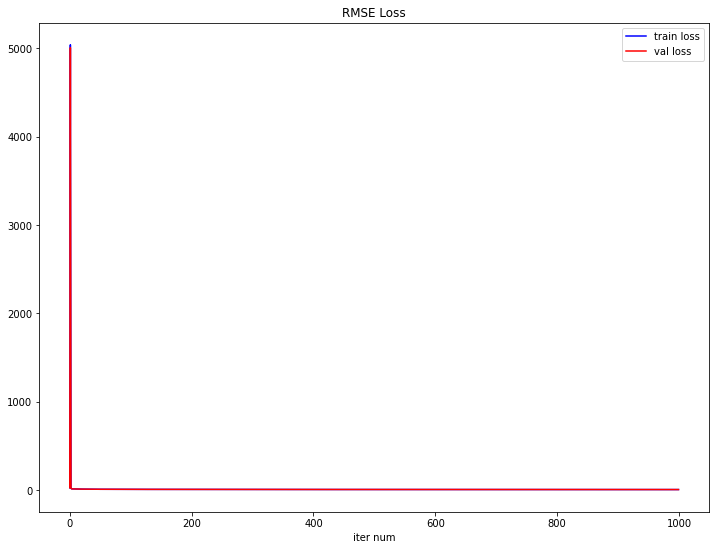

In [ ]:
plot(tra_loss_ls, val_loss_ls)

# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [ ]:
w = np.load('weight.npy')
x_test_plus = np.concatenate((x_test, np.ones([len(x_test), 1])), axis = 1).astype(float)
ans_y = predict(x_test_plus, w)
print(ans_y.shape)

(240, 1)


# **Save Prediction to CSV File**


In [ ]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 4.952777040656169]
['id_1', 17.045234787696085]
['id_2', 24.503690328353873]
['id_3', 8.78394286600292]
['id_4', 27.617055444526933]
['id_5', 21.833743921702816]
['id_6', 22.772053127817806]
['id_7', 30.955591239847614]
['id_8', 17.327268107172394]
['id_9', 58.617607017584156]
['id_10', 14.936978713767225]
['id_11', 10.148104639872365]
['id_12', 61.386268918375336]
['id_13', 52.20101090277532]
['id_14', 22.080061432881173]
['id_15', 11.379618229017554]
['id_16', 31.55111105936251]
['id_17', 67.29868515822723]
['id_18', -1.6971953689572246]
['id_19', 16.243043857734687]
['id_20', 42.68057200823533]
['id_21', 71.04584243177956]
['id_22', 9.758074360715398]
['id_23', 17.58941337557298]
['id_24', 15.364239723371771]
['id_25', 37.0952619787889]
['id_26', 13.299268278116028]
['id_27', 72.50441897640613]
['id_28', 7.27355615622627]
['id_29', 55.81935527716402]
['id_30', 21.351349392503266]
['id_31', 8.122528364831714]
['id_32', 2.929429897129772]
['id_33', 21.00008375

将submit.csv提交到kaggle，就可以看见分数了，只改了学习率,加上分train set和validation set的时候shuffle了,就已经超过了simple baseline,接近strong baseline了,加油!

相關 reference 可以參考:

Adagrad :
https://youtu.be/yKKNr-QKz2Q?list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&t=705 

RMSprop : 
https://www.youtube.com/watch?v=5Yt-obwvMHI 

Adam
https://www.youtube.com/watch?v=JXQT_vxqwIs 


以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit

# **Report**
接下来回答report要求的相关问题

# **Problem 1**
使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。


8.9254896110507
5.848501640785761
5.856910982701486
5.878210369519758


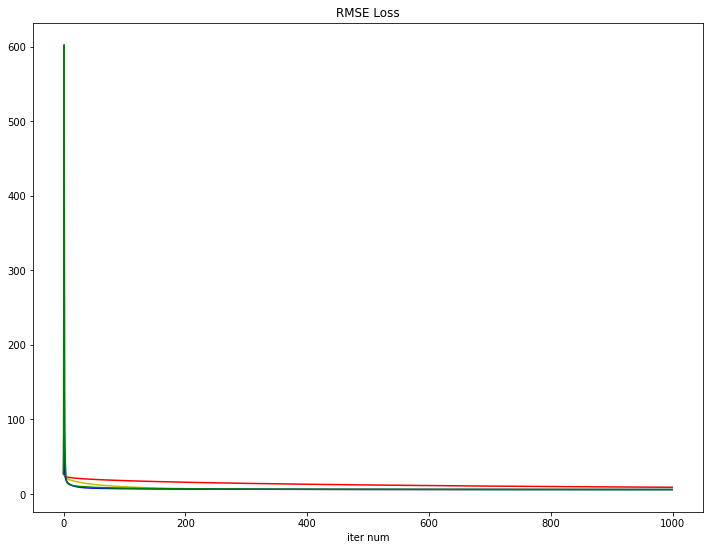

In [ ]:
lr_ls = [0.3,1,3,10]
color_ls = ['r','y','b','g']
plt.figure(figsize=(12,9))
for i, lr in enumerate(lr_ls):
  tra_loss_ls, val_loss_ls = train(x_tra, y_tra, x_val, y_val, learning_rate=lr)
  plt.plot(range(len(tra_loss_ls)), tra_loss_ls, color_ls[i])
  print(tra_loss_ls[-1])
plt.xlabel("iter num")
plt.title("RMSE Loss")
plt.show()

看起来学习率是1的时候最好，但是区别不大


# **Problem 2**
比較取前 5 hrs 和前 9 hrs 的資料（5\*18 + 1 v.s 9\*18 + 1）在 validation set 上預測的結果，並說明造成的可能原因（1. 因為 testing set 預測結果要上傳 Kaggle 後才能得知，所以在報告中並不要求同學們呈現 testing set 的結果，至於什麼是 validation set 請參考：https://youtu.be/D_S6y0Jm6dQ?t=1949 2. 9hr:取前9小時預測第10小時的PM2.5；5hr:在前面的那些features中，以5~9hr預測第10小時的PM2.5。這樣兩者在相同的validation set比例下，會有一樣筆數的資料）。

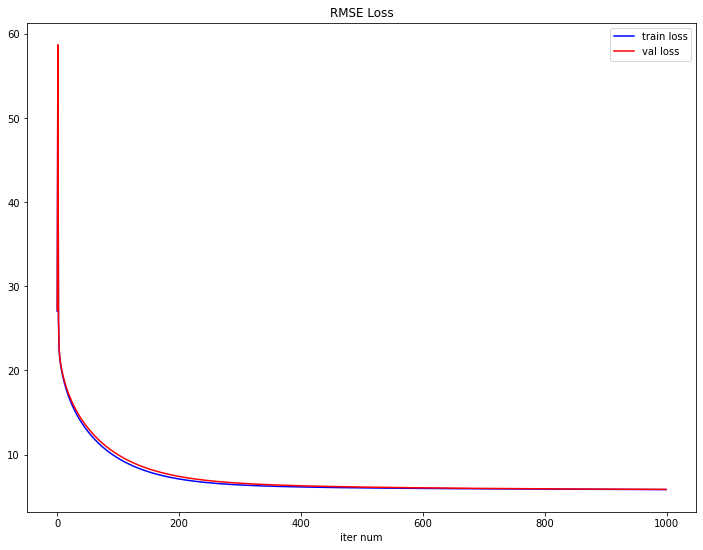

5.848501640785761
5.865961600852472


In [ ]:
# 前九个小时
tra_loss_ls_9h, val_loss_ls_9h = train(x_tra, y_tra, x_val, y_val, learning_rate=1)
w_9h = np.load('weight.npy')
plot(tra_loss_ls_9h, val_loss_ls_9h)
print(tra_loss_ls_9h[-1])
print(val_loss_ls_9h[-1])

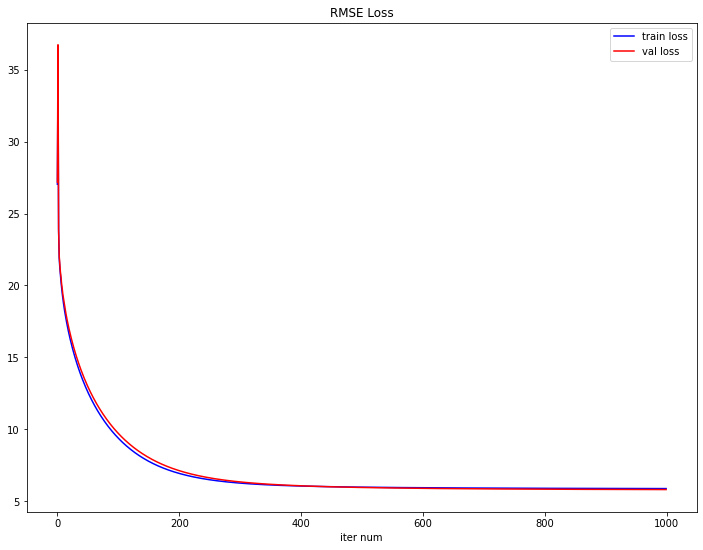

5.872792619610751
5.804161945769386


In [ ]:
# 前5个小时
x = 5
col = np.empty(18*x, dtype=int)
for i in range(18):
  col[i*x:(i+1)*x] = np.arange((i+1)*9-x,(i+1)*9)
tra_loss_ls_5h, val_loss_ls_5h = train(x_tra[:,col], y_tra, x_val[:,col], y_val, learning_rate=1)
w_5h = np.load('weight.npy')
plot(tra_loss_ls_5h, val_loss_ls_5h)
print(tra_loss_ls_5h[-1])
print(val_loss_ls_5h[-1])

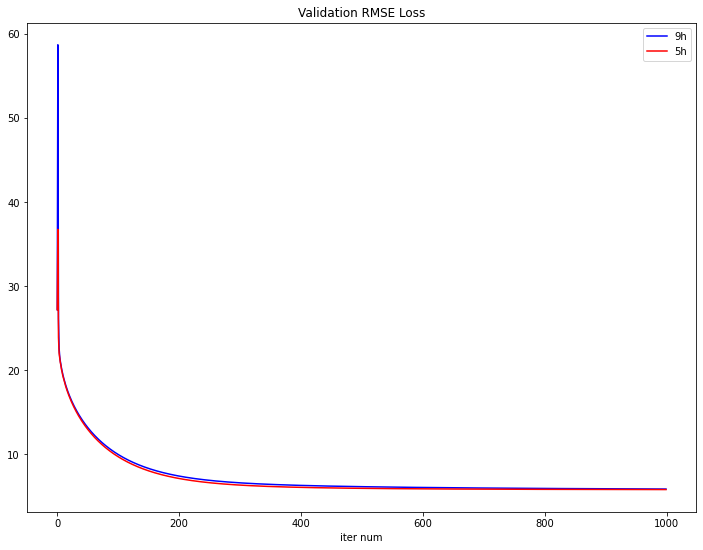

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(range(len(val_loss_ls_9h)), val_loss_ls_9h, 'b', label="9h")
plt.plot(range(len(val_loss_ls_5h)), val_loss_ls_5h, 'r', label="5h")
plt.legend()
plt.xlabel("iter num")
plt.title("Validation RMSE Loss")
plt.show()

loss曲线几乎一模一样,5-9h的feature训练出来的model在validation set上的表现稍微好了一丢丢,让我们来看看model的weight把

In [ ]:
row = np.concatenate((col, np.ones(1,dtype=int)*18*9))#加上bias
print(np.sqrt(np.sum(np.power(w_9h[row,:]-w_5h, 2))/len(w_5h)))#w_9h对应的w和w_5h的均方根差
print(np.mean(np.abs(w_9h), axis=0))
print(np.mean(np.abs(w_9h[row,:]), axis=0))
op_row = np.empty(18*4, dtype=int)
for i in range(18):
  op_row[i*4:(i+1)*4] = np.arange(i*9,i*9+4)
print(np.mean(np.abs(w_9h[op_row,:]), axis=0))

0.2755414099151927
[0.5170086]
[0.75921349]
[0.21088853]


可以看出,w_9h中对应5-9h的weight和w_5h差距不大.而在w_9h中,1-4h对应的参数的平局绝对值大小是5-9h对应的参数的平均绝对值大小的1/3,可以看出1-4h的feature对model的影响不大,而这个结论也是符合常理的,即当前的PM2.5指数更取决于不久之前的空气指数.

用5-9h的feature训练出来的模型在train set上的表现比用9h的model训练差一点,这个符合常理,因为只用前五个小时feature的model更简单,而且说明优化没问题.而用5-9h的feature训练出来的模型在validation set上的表现比用9h的model训练更好一点,让人怀疑存在过拟合.

综上认为5-9h的feature比9h的feature更好.

# **Problem 3**
比較只取前9hrs的PM2.5和取所有前9hrs的features（9\*1+1 vs. 9\*18+1）在validation set上預測的結果，並說明造成的可能原因。


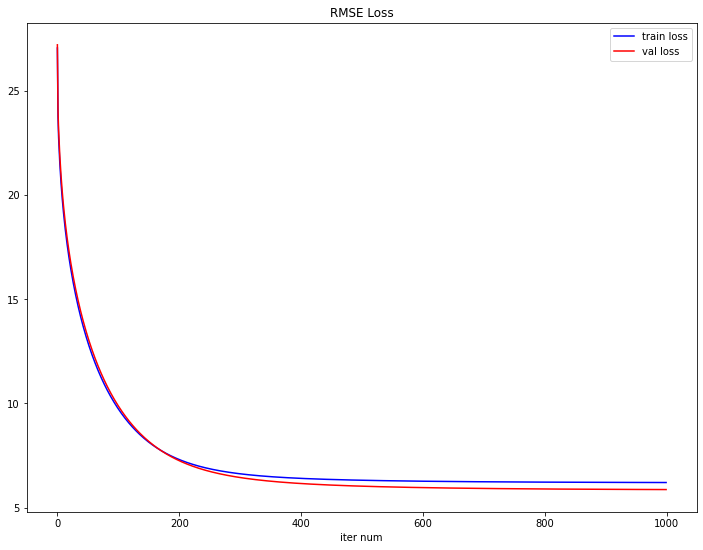

6.209443899494031
5.871966567678769


In [ ]:
# 只取前九个小时的PM2.5做Feature
pm25_col = np.arange(9*9, 9*10)
tra_loss_ls_pm25, val_loss_ls_pm25 = train(x_tra[:,pm25_col], y_tra, x_val[:,pm25_col], y_val, learning_rate=1)
w_pm25 = np.load('weight.npy')
plot(tra_loss_ls_pm25, val_loss_ls_pm25)
print(tra_loss_ls_pm25[-1])
print(val_loss_ls_pm25[-1])

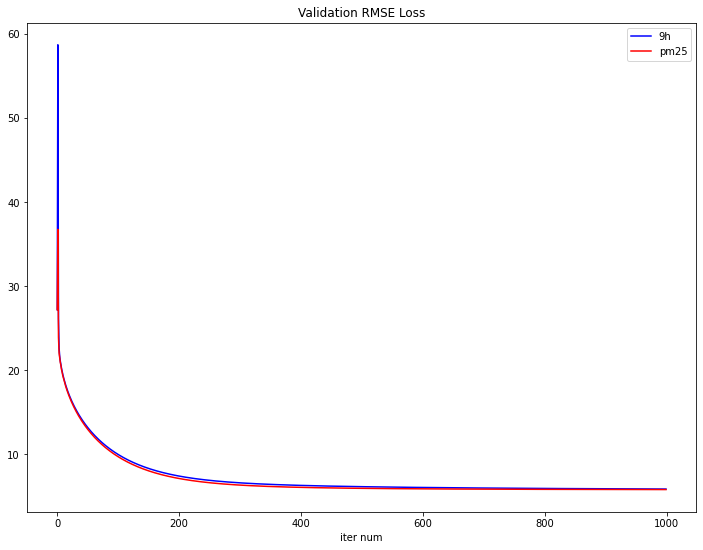

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(range(len(val_loss_ls_9h)), val_loss_ls_9h, 'b', label="9h")
plt.plot(range(len(val_loss_ls_pm25)), val_loss_ls_5h, 'r', label="pm25")
plt.legend()
plt.xlabel("iter num")
plt.title("Validation RMSE Loss")
plt.show()

只用PM2.5的结果又稍微差了一点(both in train set and validation set),可能模型过于简单，存在欠拟合,也说明其他特征也起了作用。

# **Problem 4**
請說明你超越 baseline 的 model(最後選擇在Kaggle上提交的) 是如何實作的（例如：怎麼進行 feature selection, 有沒有做 pre-processing、learning rate 的調整、advanced gradient descent 技術、不同的 model 等等）。

## **Try 1**
Problem 3显示只用前9h的PM2.5指数作为feature存在着欠拟合，但是模型的表现和用前9h的所有空气质量指数作为feature相比，差距并不大，说明PM2.5指数这个feature不错，所以我们尝试使用PM2.5指数，PM2.5指数的平方，PM2.5指数的三次方作为feature来做训练。

6.320921082690651
6.107500034625243


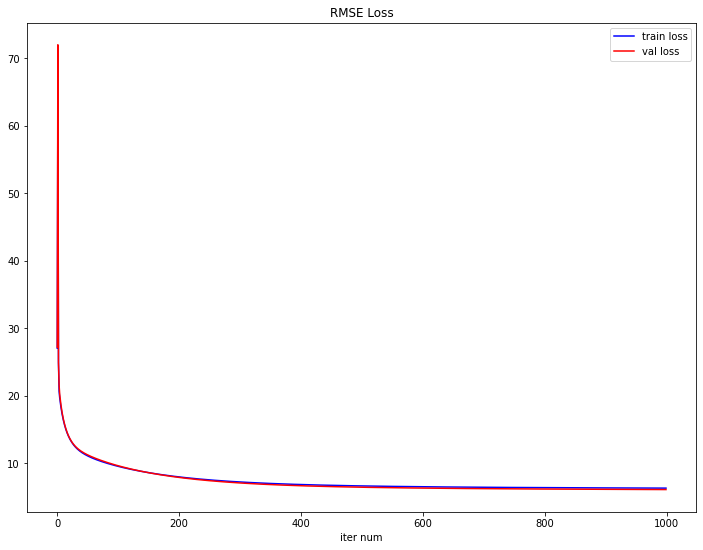

In [ ]:
# try 1
pm25_col = np.arange(9*9, 9*10)
x_tra_pm25 = x_tra[:,pm25_col]
x_val_pm25 = x_val[:,pm25_col]
x_tra__pm25_power = np.concatenate((x_tra_pm25, np.power(x_tra_pm25, 2), np.power(x_tra_pm25, 3)), axis = 1).astype(float)
x_val__pm25_power = np.concatenate((x_val_pm25, np.power(x_val_pm25, 2), np.power(x_val_pm25, 3)), axis = 1).astype(float)
tra_loss_ls, val_loss_ls = train(x_tra__pm25_power, y_tra, x_val__pm25_power, y_val, iter_time=1000, learning_rate=1)
print(tra_loss_ls[-1])
print(val_loss_ls[-1])
plot(tra_loss_ls, val_loss_ls)

模型比只用PM2.5作为feature更差了(both in tra and val)，感觉是优化出了问题，我们换adam试试

In [ ]:
# 首先修改一下train()
def train(x_tra, y_tra, x_val, y_val, iter_time=1000, learning_rate=0.1, save_w=True):
  dim = x_tra.shape[1]+1
  w = np.zeros([dim, 1]) # weight
  x_tra = np.concatenate((x_tra, np.ones([len(x_tra), 1])), axis = 1).astype(float)
  x_val = np.concatenate((x_val, np.ones([len(x_val), 1])), axis = 1).astype(float)
  beta1, beta2, eps = 0.9, 0.999, 1e-6
  momentum = np.zeros([dim, 1])
  rmsprop = np.zeros([dim, 1])
  tra_loss_ls = np.empty(iter_time, dtype=float)
  val_loss_ls = np.empty(iter_time, dtype=float)
  for t in range(iter_time):
    tra_loss = loss(predict(x_tra, w), y_tra)#rmse
    val_loss = loss(predict(x_val, w), y_val)
    tra_loss_ls[t] = tra_loss
    val_loss_ls[t] = val_loss
    gradient = 2 * np.dot(x_tra.transpose(), predict(x_tra, w) - y_tra) #dim*1
    momentum = beta1*momentum + (1-beta1)*gradient
    rmsprop = beta2*rmsprop + (1-beta2)*np.power(gradient, 2)
    momentum_corr = momentum / (1 - beta1**(t+1))
    rmsprop_corr = rmsprop / (1 - beta2**(t+1))
    w = w - learning_rate * momentum_corr / np.sqrt(rmsprop_corr + eps)
  if save_w:
    np.save('weight.npy', w)
  return tra_loss_ls, val_loss_ls

6.143920354570819
5.874679861792862


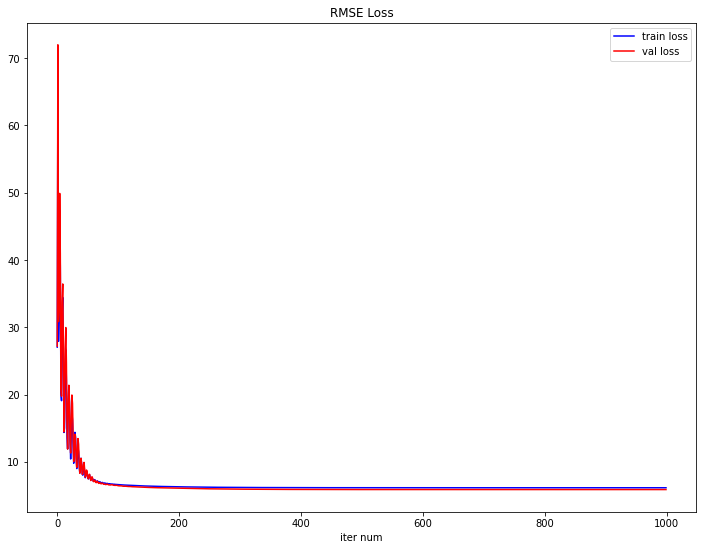

In [ ]:
x_tra__pm25_power = np.concatenate((x_tra_pm25, np.power(x_tra_pm25, 2), np.power(x_tra_pm25, 3)), axis = 1).astype(float)
x_val__pm25_power = np.concatenate((x_val_pm25, np.power(x_val_pm25, 2), np.power(x_val_pm25, 3)), axis = 1).astype(float)
tra_loss_ls, val_loss_ls = train(x_tra__pm25_power, y_tra, x_val__pm25_power, y_val, iter_time=1000, learning_rate=1)
print(tra_loss_ls[-1])
print(val_loss_ls[-1])
plot(tra_loss_ls, val_loss_ls)

我们再看看只用pm2.5做feature，但是用adam优化的结果

6.194136200335864
5.846321340769987


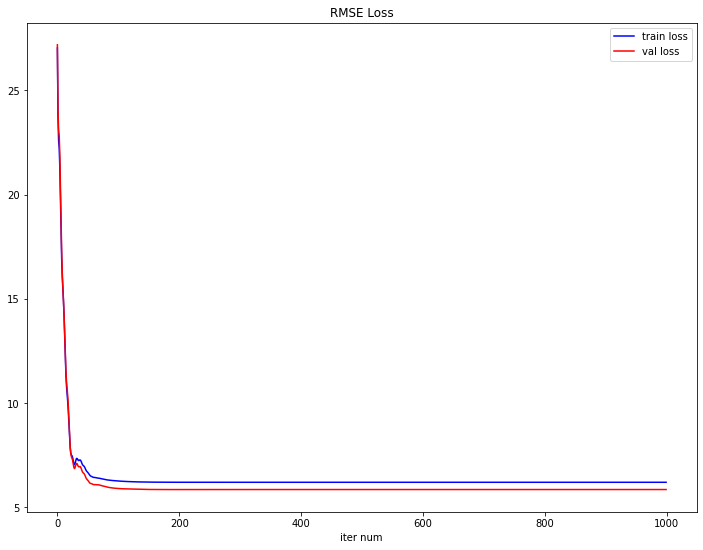

In [ ]:
tra_loss_ls, val_loss_ls = train(x_tra[:,pm25_col], y_tra, x_val[:,pm25_col], y_val, iter_time=1000, learning_rate=1)
print(tra_loss_ls[-1])
print(val_loss_ls[-1])
plot(tra_loss_ls, val_loss_ls)

观察此时用了三次方的model在train set上表现更好，但是validation set上表现更差，说明存在过拟合，加入正则化试试。

In [ ]:
# 首先修改一下train()
def train(x_tra, y_tra, x_val, y_val, iter_time=1000, learning_rate=0.1, save_w=True, lada=1):
  dim = x_tra.shape[1]+1
  w = np.zeros([dim, 1]) # weight
  x_tra = np.concatenate((x_tra, np.ones([len(x_tra), 1])), axis = 1).astype(float)
  x_val = np.concatenate((x_val, np.ones([len(x_val), 1])), axis = 1).astype(float)
  beta1, beta2, eps = 0.9, 0.999, 1e-6
  momentum = np.zeros([dim, 1])
  rmsprop = np.zeros([dim, 1])
  tra_loss_ls = np.empty(iter_time, dtype=float)
  val_loss_ls = np.empty(iter_time, dtype=float)
  for t in range(iter_time):
    tra_loss = loss(predict(x_tra, w), y_tra)#rmse
    val_loss = loss(predict(x_val, w), y_val)
    tra_loss_ls[t] = tra_loss
    val_loss_ls[t] = val_loss
    gradient = 2 * np.dot(x_tra.transpose(), predict(x_tra, w) - y_tra) + 2*lada*w #dim*1
    momentum = beta1*momentum + (1-beta1)*gradient
    rmsprop = beta2*rmsprop + (1-beta2)*np.power(gradient, 2)
    momentum_corr = momentum / (1 - beta1**(t+1))
    rmsprop_corr = rmsprop / (1 - beta2**(t+1))
    w = w - learning_rate * momentum_corr / np.sqrt(rmsprop_corr + eps)
  if save_w:
    np.save('weight.npy', w)
  return tra_loss_ls, val_loss_ls

6.14397579938638
5.875940779124316


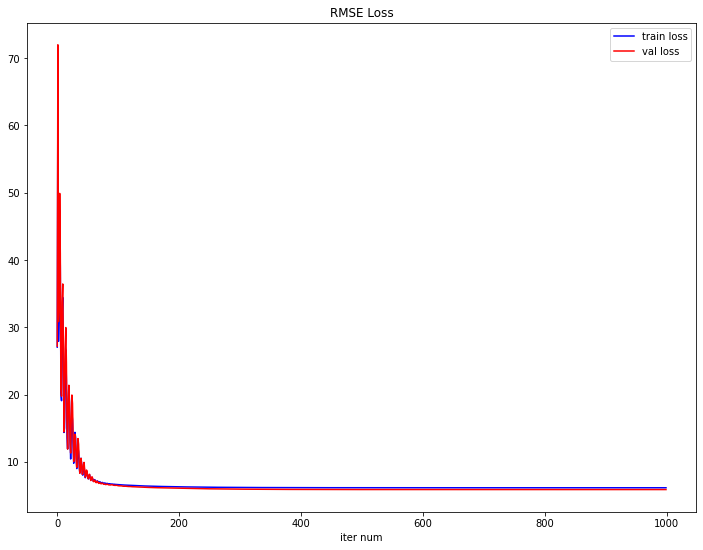

In [ ]:
x_tra__pm25_power = np.concatenate((x_tra_pm25, np.power(x_tra_pm25, 2), np.power(x_tra_pm25, 3)), axis = 1).astype(float)
x_val__pm25_power = np.concatenate((x_val_pm25, np.power(x_val_pm25, 2), np.power(x_val_pm25, 3)), axis = 1).astype(float)
tra_loss_ls, val_loss_ls = train(x_tra__pm25_power, y_tra, x_val__pm25_power, y_val, iter_time=1000, learning_rate=1, lada=1)
print(tra_loss_ls[-1])
print(val_loss_ls[-1])
plot(tra_loss_ls, val_loss_ls)

测试了多组正则项，但是表现没有明显的改善，说明加入pm25的多次项并没有太大用，但是采用adam的优化效果明显更好，后续可以继续使用。

## **Try 2**
Problem 2里面显示了用前9h的空气质量指数可能存在过拟合，直接使用5-9h的空气质量指数在validation set上表现更好，所以我们不妨在训练是加入过拟合，并使用try 1中证明更有效果的adam优化。

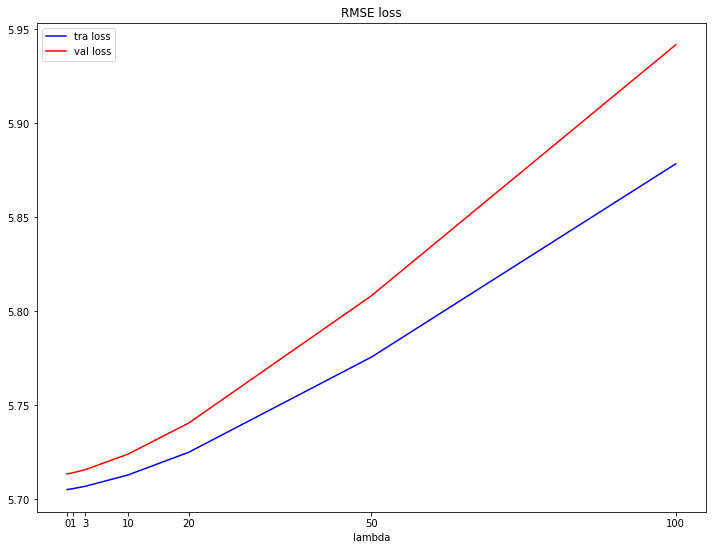

In [ ]:
# 9h
lada_ls = [0, 1, 3, 10, 20, 50 ,100]
tra_final_loss = []
val_final_loss = []
for ld in lada_ls:
  tra_loss_ls, val_loss_ls = train(x_tra, y_tra, x_val, y_val, iter_time=500, learning_rate=1, lada=ld)
  tra_final_loss.append(tra_loss_ls[-1])
  val_final_loss.append(val_loss_ls[-1])

plt.figure(figsize=(12,9))
plt.plot(lada_ls, tra_final_loss, 'b', label='tra loss')
plt.plot(lada_ls, val_final_loss, 'r', label='val loss')
plt.legend()
plt.xlabel("lambda")
plt.xticks(lada_ls, lada_ls)
plt.title("RMSE loss")
plt.show()

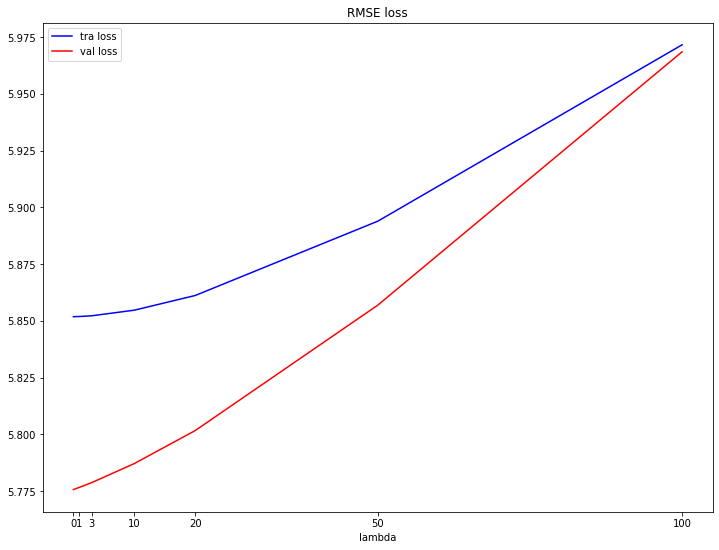

In [ ]:
# 前5个小时
x = 5
col = np.empty(18*x, dtype=int)
for i in range(18):
  col[i*x:(i+1)*x] = np.arange((i+1)*9-x,(i+1)*9)

lada_ls = [0, 1, 3, 10, 20, 50 ,100]
tra_final_loss = []
val_final_loss = []
for ld in lada_ls:
  tra_loss_ls_5h, val_loss_ls_5h = train(x_tra[:,col], y_tra, x_val[:,col], y_val, iter_time=500, learning_rate=1, lada=ld)
  tra_final_loss.append(tra_loss_ls_5h[-1])
  val_final_loss.append(val_loss_ls_5h[-1])
plt.figure(figsize=(12,9))
plt.plot(lada_ls, tra_final_loss, 'b', label='tra loss')
plt.plot(lada_ls, val_final_loss, 'r', label='val loss')
plt.legend()
plt.xlabel("lambda")
plt.xticks(lada_ls, lada_ls)
plt.title("RMSE loss")
plt.show()

看起来正则化并没有用，所以说明其实，9h的空气质量做feature并没有过拟合。仔细回想之前的结果差距其实很小，可能只是数值误差。这里的进步主要还是来源于adam的优化。
所以我们直接提交一发看看效果。

5.68367576305614
5.511799319545707


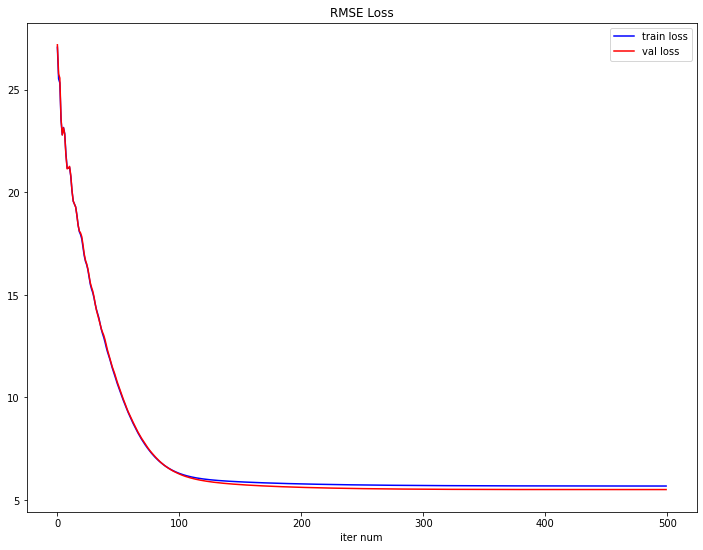

In [ ]:
# 用全部训练集
x = np.concatenate((x_tra, x_val), axis = 0).astype(float)
y = np.concatenate((y_tra, y_val), axis = 0).astype(float)
tra_loss_ls, val_loss_ls = train(x, y, x_val, y_val, iter_time=500, learning_rate=0.3, lada=0)
print(tra_loss_ls[-1])
print(val_loss_ls[-1])
plot(tra_loss_ls, val_loss_ls)

In [ ]:
# 不出意外结果好了一些，直接预测提交
w = np.load('weight.npy')
x_test_plus = np.concatenate((x_test, np.ones([len(x_test), 1])), axis = 1).astype(float)
ans_y = predict(x_test_plus, w)
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

结果显示在public test已经达到了strong baseline,但是private test还差一点到baseline，还需要继续改进.

感觉已经接近线性回归模型的极限，手动设计特征实在过于复杂，所以采用神经网络模型自动学习特征。

## **Try 3**

## **读取数据**
修改一下之前的数据处理函数，去掉归一化和分训练集和验证集的操作，便于接下来的特征工程。

In [ ]:
def get_dataset():
  # 数据处理
  data = pd.read_csv('./train.csv', encoding = 'big5')
  data = data.iloc[:, 3:]
  data[data == 'NR'] = 0
  raw_data = data.to_numpy()
  # 特征提取(1)
  month_data = {}
  for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
  # 特征提取(2))
  x = np.empty([12 * 471, 18 * 9], dtype = float)
  y = np.empty([12 * 471, 1], dtype = float)
  for month in range(12):
    for day in range(20):
      for hour in range(24):
        if day == 19 and hour > 14:
          continue
        x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) 
        #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
        y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value


  # 测试集
  # testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
  testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
  testdata[testdata == 'NR'] = 0
  test_data = testdata.iloc[:, 2:]
  test_data = test_data.to_numpy()
  x_test = np.empty([240, 18*9], dtype = float)
  for i in range(240):
    x_test[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)

  return x, y, x_test

In [ ]:
x, y, x_test = get_dataset()

## **特征工程**

In [ ]:
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

先观察训练集和测试集的分布是否一致

In [ ]:
pd.DataFrame(x).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161
count,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.00000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.00000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,...,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000
mean,22.536518,22.543241,22.549788,22.553680,22.555980,22.556228,22.556246,22.555255,22.551716,1.702389,1.70230,1.702176,1.702141,1.702017,1.701964,1.701893,1.701858,1.701787,0.389034,0.388935,0.38896,0.389167,0.389335,0.389370,0.389305,0.389071,0.388581,0.140154,0.140188,0.140439,0.140796,0.141014,0.141086,0.141127,0.141095,0.140916,2.147435,2.150336,2.152512,2.155078,...,1.839897,1.839809,1.839703,1.839473,156.305839,156.543100,156.717197,156.752937,156.738075,156.697558,156.724098,156.735067,156.780538,158.586323,158.755113,158.904972,158.894285,158.858192,158.961872,158.971957,158.980096,159.008227,2.297010,2.299628,2.301645,2.302353,2.303751,2.304388,2.305750,2.305538,2.306122,1.713924,1.714473,1.714260,1.714260,1.714614,1.715198,1.715623,1.716419,1.716826
std,6.285479,6.287717,6.290764,6.293628,6.296279,6.299106,6.302129,6.305178,6.308659,0.125889,0.12587,0.125851,0.125852,0.125861,0.125883,0.125898,0.125912,0.125913,0.326165,0.326129,0.32610,0.326084,0.326089,0.326078,0.326072,0.326036,0.325897,0.104465,0.104449,0.104696,0.105075,0.105216,0.105199,0.105186,0.105159,0.105090,2.296300,2.298123,2.297926,2.298486,...,0.182519,0.182543,0.182518,0.182456,95.771475,95.884426,95.997659,96.059023,96.084810,96.072108,96.106613,96.117831,96.113187,94.774861,94.859122,94.926056,94.940252,94.953930,95.001803,95.008098,95.022444,94.997223,1.068175,1.068399,1.069211,1.069356,1.068882,1.068257,1.067967,1.067976,1.067339,1.065901,1.065921,1.066671,1.067808,1.067792,1.067151,1.067147,1.067474,1.066717
min,-12.300000,-12.300000,-12.300000,-12.300000,-12.300000,-12.300000,-12.300000,-12.300000,-12.300000,-0.200000,-0.20000,-0.200000,-0.200000,-0.200000,-0.200000,-0.200000,-0.200000,-0.200000,-0.120000,-0.120000,-0.12000,-0.120000,-0.120000,-0.120000,-0.120000,-0.120000,-0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.100000,-1.100000,-1.100000,-1.100000,...,-0.200000,-0.200000,-0.200000,-0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.600000,1.60000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,0.250000,0.250000,0.25000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,0.070000,1.100000,1.100000,1.100000,1.100000,...,1.700000,1.700000,1.700000,1.700000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,

In [ ]:
pd.DataFrame(x_test).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,23.119583,23.166667,23.287500,23.357917,23.412500,23.402500,23.404583,23.389583,23.488750,1.720417,1.717917,1.71500,1.716250,1.716250,1.714167,1.717500,1.711667,1.712917,0.394833,0.404292,0.406875,0.399542,0.403292,0.395458,0.397167,0.393875,0.392500,0.148708,0.157583,0.154667,0.156292,0.158792,0.156333,0.154792,0.146542,0.153625,2.055833,2.349583,2.146667,2.371667,...,1.872500,1.869583,1.859583,1.860000,172.854167,176.838333,172.675833,169.200833,177.097500,181.537500,179.600000,177.404167,175.429583,173.475000,174.280833,171.532500,173.687500,174.283333,180.604167,181.029167,173.087083,168.362083,2.180000,2.169167,2.123333,2.115417,2.186667,2.161250,2.315000,2.238333,2.168333,1.714583,1.764583,1.718333,1.651250,1.673333,1.731667,1.777917,1.789583,1.742083
std,5.835054,5.777432,5.651298,5.571094,5.544171,5.656521,5.722219,5.750192,5.762612,0.087503,0.087095,0.08399,0.082498,0.080962,0.079534,0.080441,0.079941,0.140679,0.215919,0.211289,0.245447,0.193759,0.195353,0.185530,0.231331,0.313915,0.213164,0.093413,0.114399,0.104513,0.101796,0.103511,0.104753,0.100866,0.089961,0.109605,1.828542,2.774857,1.925340,2.967246,...,0.153597,0.146764,0.143739,0.203073,91.958420,93.805371,97.294739,96.972862,96.196902,95.413561,95.197957,97.453600,97.116789,92.898015,94.495765,96.778235,95.179407,93.610667,96.289604,94.102206,95.748616,94.867380,1.089555,1.173294,1.031328,1.035546,0.992814,1.002736,1.162824,1.197954,1.164681,1.043367,1.110974,1.076721,1.002924,0.951258,0.989145,1.111697,1.161740,1.203490
min,7.700000,7.700000,8.100000,8.000000,7.800000,7.800000,7.700000,7.700000,8.400000,1.500000,1.500000,1.50000,1.500000,1.500000,1.500000,1.500000,1.500000,0.000000,0.090000,0.090000,0.090000,0.090000,0.110000,0.100000,0.110000,0.110000,0.110000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.010000,0.010000,-0.300000,-0.300000,-0.400000,-0.400000,...,1.600000,1.600000,1.600000,0.000000,13.000000,0.200000,3.000000,0.200000,5.700000,19.000000,14.000000,4.000000,8.100000,16.000000,6.600000,4.800000,14.000000,10.000000,15.000000,16.000000,0.900000,0.900000,0.500000,0.500000,0.500000,0.500000,0.600000,0.500000,0.500000,0.500000,0.500000,0.200000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.300000
25%,19.000000,19.750000,20.000000,20.000000,19.000000,19.000000,19.000000,20.000000,20.000000,1.700000,1.700000,1.70000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,0.250000,0.250000,0.250000,0.260000,0.250000,0.260000,0.270000,0.260000,0.250000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,1.100000,1.200000,1.200000,1.200000,...,1.800000,1.800000,1.800000,1.800000,101.000000,103.750000,102.000000,94.750000,101.000000,104.000000,105.750000,102.000000,101.000000,102.000000,100.500000,96.250000,100.000000,101.000000,105.000000,106.

看着大致分布一样，但是总觉得测试集有些数据要比训练集大一些，存在一点偏移。我们画出KDE曲线看看。

In [ ]:
for i in range(9*18):
  sns.kdeplot(x[i], shade = True, color='r', label = 'train')
  sns.kdeplot(x_test[i], shade = True, color='b', label = 'test')
  plt.xlabel(f'Feature {i}')
  plt.legend()
  plt.show()


# 此为错误管观点，留作纪念
'''
观察分布得到评价
match_index = [0,1,3,4,6,9,14,15,16,18,19,20,24,26,27,28,32,33,36,37,43,46,49,50,52,58,61,64,65,66,67,68,71,73,75,77,80,82,84,85,86,87,90,92,96,98,100,103,104,106,114,115,117,119,121,123,126,127,128,129,130,131,132,133,135,140,144,147,154,156,161]
mismatch_index =[2,5,7,8,10,11,12,13,17,21,22,23,25,29,30,31,34,35,38,39,40,41,42,44,45,47,48,51,53,54,55,56,57,59,60,62,63,69,70,72,74,76,78,79,81,83,88,89,91,93,94,95,97,99,101,102,105,107,108,109,110,111,112,113,116,118,120,122,124,125,134,136,137,138,139,141,142,143,145,148,149,150,151,152,153,155,157,158,159,160]
都是在比较大的位置，数据分布有差异
'''

Output hidden; open in https://colab.research.google.com to view.

总的来说分布还是比较match的，可能只是有一点异常值。

接下来看看这个哪些特征比较重要

In [ ]:
# selector = SelectKBest(lambda X,Y:list(np.array(list(map(lambda xi:pearsonr(xi,Y),X.T))).T),k=10)

# 相关系数筛选一波
fselector = SelectKBest(f_regression, k=10)
x_fselect = fselector.fit_transform(x,y.reshape(len(y)))
print(x_fselect.shape)
fscores = fselector.scores_
fselect_col_index = np.argsort(fscores)[-1:-11:-1]
print(fselect_col_index)
print(fscores[fselect_col_index])
# careful selector 返回的array的列不是完全按分数降序来的

# 互信息筛选一波
micselector = SelectKBest(mutual_info_regression, k=10)
x_micselect = micselector.fit_transform(x,y.reshape(len(y)))
print(x_micselect.shape)
micscores = micselector.scores_
micselect_col_index = np.argsort(micscores)[-1:-11:-1]
print(micselect_col_index)
print(micscores[micselect_col_index])

(5652, 10)
[89 88 80 79 87 78 86 77 85 76]
[28834.57053945 11349.11169957  7572.69803111  5866.55435945
  5541.42638478  4343.98088717  4128.40016431  3241.76794442
  3090.17712981  2488.7131543 ]
(5652, 10)
[89 88 80 87 79 86 78 85 77 26]
[0.91255496 0.56844978 0.40904157 0.36225202 0.32005482 0.30678602
 0.2645481  0.22290916 0.21801369 0.20419679]


两个筛选结果非常相似，我们采用mic来选择特征

In [ ]:
def get_mic_index(n):
  micselector = SelectKBest(mutual_info_regression, k=n)
  micselector.fit_transform(x,y.reshape(len(y)))
  micscores = micselector.scores_
  micselect_col_index = np.argsort(micscores)[-1:-11:-1]
  return micselect_col_index

获得任意前n个小时数据的特征index（原来是使用前3h，前6h，前9h的特征作为模型的输入，后面实验结果显示mic更好用）

In [ ]:
def get_xh_index(n):
  col = np.empty(18*n, dtype=int)
  for i in range(18):
    col[i*n:(i+1)*n] = np.arange((i+1)*9-n,(i+1)*9)
  return col

## **归一化**

In [ ]:
# 随机打乱
np.random.seed(0) # 固定随机种子，保证其他条件一致
# 放一起shuffle,分开就乱了
xy = np.concatenate((x, y), axis = 1).astype(float)
np.random.shuffle(xy)
x = xy[:,:-1]
y = xy[:,-1].reshape((len(y),1))

# 归一化
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
  for j in range(len(x[0])): #18 * 9 
    if std_x[j] != 0:
      x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

for i in range(len(x_test)):
  for j in range(len(x_test[0])):
    if std_x[j] != 0:
      x_test[i][j] = (x_test[i][j] - mean_x[j]) / std_x[j]

## **模型**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset

In [ ]:
# 模型融合
class NeuralNetwork(nn.Module):
  def __init__(self, inputsize, id):
    super(NeuralNetwork, self).__init__()
    if id==1:
      self.linear_relu_stack = nn.Sequential(
        nn.Linear(inputsize, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
      )
    elif id==2:
      self.linear_relu_stack = nn.Sequential(
        nn.Linear(inputsize, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
      )
    elif id==3:
      self.linear_relu_stack = nn.Sequential(
        nn.Linear(inputsize, 128),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1)
      )
    elif id==4:
      self.linear_relu_stack = nn.Sequential(
        nn.Linear(inputsize, 16),
        nn.ReLU(),
        nn.Linear(16, 1)
      )

  def forward(self, x):
    y_pred = self.linear_relu_stack(x)
    return y_pred

## **训练**

In [ ]:
class MyDataset(Dataset):
  def __init__(self, x, y, transform=None, target_transform=None):
    self.x = x
    self.y = y
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    x_item = self.x[idx]
    y_item = self.y[idx]
    if self.transform:
      x_item = self.transform(x_item)
    if self.target_transform:
      y_item = self.target_transform(y_item)
    # if torch.cuda.is_available():
    #   x_item = x_item.to('cuda')
    #   y_item = y_item.to("cuda")
    return x_item, y_item


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    if torch.cuda.is_available():
      X = X.to('cuda')
      y = y.to("cuda")

    # Compute prediction and loss
    model.train()
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 5 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {np.sqrt(loss):>7f}  [{current:>5d}/{size:>5d}]")


def val_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      if torch.cuda.is_available():
        X = X.to('cuda')
        y = y.to("cuda")
      model.eval()
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  # correct /= size
  print(f"val Avg loss: {np.sqrt(test_loss):>8f} \n")
  return np.sqrt(test_loss)
  # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
# hype parameter
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 0.001
epochs = 10000 #加了早停可以取得大一点
k = 8 #k cross validation


# select feature
select_indexes = []
for n in [10, 30, 100]:# 前n好
  select_indexes.append(get_mic_index(n))

# stacking
new_x = np.empty((len(x),3), dtype="float32")
new_x_test = np.zeros((len(x_test),3), dtype="float32")
for i,select_index in enumerate(select_indexes): #every model
  for j in range(k): #k cross validation
    # data loader
    val_row = list(range(math.floor(len(x)*j/k), math.floor(len(x)*(j+1)/k)))
    train_row = list(range(0, math.floor(len(x)*j/k))) + list(range(math.floor(len(x)*(j+1)/k), len(x)))
    train_data = MyDataset(torch.from_numpy(x[train_row,:][:,select_index].astype("float32")), torch.from_numpy(y[train_row,:].astype("float32")))
    val_data = MyDataset(torch.from_numpy(x[val_row,:][:,select_index].astype("float32")), torch.from_numpy(y[val_row,:].astype("float32")))
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    # train
    model = NeuralNetwork(len(select_index), i+1).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    min_loss = 10e5
    early_stop = 100 #容忍一百次
    cnt = 0
    para = {}
    for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(train_dataloader, model, loss_fn, optimizer)
      cur_loss = val_loop(val_dataloader, model, loss_fn)
      if(cur_loss < min_loss):
        cnt = 0
        min_loss = cur_loss
        para = model.state_dict()
      else:
        cnt += 1
      if cnt>early_stop:
        break
    print(f"Done!({i},{j})")
    print(min_loss)
    model.load_state_dict(para)
    new_x[val_row, i] = model(torch.from_numpy(x[val_row,:][:,select_index].astype("float32"))).detach().cpu().numpy().reshape(len(val_row))
    new_x_test[:,i] = new_x_test[:,i] + model(torch.from_numpy(x_test[:,select_index].astype("float32"))).detach().cpu().numpy().reshape(len(x_test))
new_x_test = new_x_test/k

流式输出内容被截断，只能显示最后 5000 行内容。
loss: 7.476306  [  640/ 4946]
loss: 4.616371  [  960/ 4946]
loss: 6.019779  [ 1280/ 4946]
loss: 5.392682  [ 1600/ 4946]
loss: 4.847792  [ 1920/ 4946]
loss: 5.530040  [ 2240/ 4946]
loss: 5.127353  [ 2560/ 4946]
loss: 5.675753  [ 2880/ 4946]
loss: 4.780468  [ 3200/ 4946]
loss: 7.150495  [ 3520/ 4946]
loss: 5.156212  [ 3840/ 4946]
loss: 4.607540  [ 4160/ 4946]
loss: 4.804244  [ 4480/ 4946]
loss: 7.859234  [ 4800/ 4946]
val Avg loss: 5.808829 

Epoch 24
-------------------------------
loss: 6.658243  [    0/ 4946]
loss: 5.353848  [  320/ 4946]
loss: 5.384237  [  640/ 4946]
loss: 6.345578  [  960/ 4946]
loss: 4.645291  [ 1280/ 4946]
loss: 6.733175  [ 1600/ 4946]
loss: 5.420798  [ 1920/ 4946]
loss: 5.272241  [ 2240/ 4946]
loss: 4.936644  [ 2560/ 4946]
loss: 5.177670  [ 2880/ 4946]
loss: 5.329333  [ 3200/ 4946]
loss: 7.058965  [ 3520/ 4946]
loss: 4.827009  [ 3840/ 4946]
loss: 5.705931  [ 4160/ 4946]
loss: 9.320143  [ 4480/ 4946]
loss: 5.199552  [ 4800/ 4946]
val Avg

## **模型融合**

In [ ]:
# hype parameter
epochs = 300 #防止过拟合取小一点

# data loader
train_data = MyDataset(torch.from_numpy(new_x.astype("float32")), torch.from_numpy(y.astype("float32")))
val_data = MyDataset(torch.from_numpy(new_x.astype("float32")), torch.from_numpy(y.astype("float32")))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
# train
model = NeuralNetwork(len(new_x[0]), 4).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
min_loss = 10e5
early_stop = 10 #容忍十次，防止过拟合
cnt = 0
para = {}
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  cur_loss = val_loop(val_dataloader, model, loss_fn)
  if(cur_loss < min_loss):
    cnt = 0
    min_loss = cur_loss
    para = model.state_dict()
  else:
    cnt += 1
  if cnt>early_stop:
    break
print(min_loss)
model.load_state_dict(para)

Epoch 1
-------------------------------
loss: 34.013122  [    0/ 5652]
loss: 24.203501  [  320/ 5652]
loss: 21.698064  [  640/ 5652]
loss: 25.991996  [  960/ 5652]
loss: 20.350055  [ 1280/ 5652]
loss: 18.356582  [ 1600/ 5652]
loss: 17.587586  [ 1920/ 5652]
loss: 17.339431  [ 2240/ 5652]
loss: 14.244726  [ 2560/ 5652]
loss: 14.975166  [ 2880/ 5652]
loss: 11.301051  [ 3200/ 5652]
loss: 13.718275  [ 3520/ 5652]
loss: 13.162008  [ 3840/ 5652]
loss: 7.809119  [ 4160/ 5652]
loss: 7.699254  [ 4480/ 5652]
loss: 7.198476  [ 4800/ 5652]
loss: 7.700178  [ 5120/ 5652]
loss: 6.539334  [ 5440/ 5652]
val Avg loss: 6.743981 

Epoch 2
-------------------------------
loss: 5.228686  [    0/ 5652]
loss: 5.673247  [  320/ 5652]
loss: 10.479316  [  640/ 5652]
loss: 6.526969  [  960/ 5652]
loss: 6.276199  [ 1280/ 5652]
loss: 4.599522  [ 1600/ 5652]
loss: 5.431335  [ 1920/ 5652]
loss: 5.439068  [ 2240/ 5652]
loss: 6.161643  [ 2560/ 5652]
loss: 5.803891  [ 2880/ 5652]
loss: 5.398228  [ 3200/ 5652]
loss: 6.249

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  ans_y = model(torch.from_numpy(new_x_test.astype("float32"))).cpu().numpy()
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 5.08045]
['id_1', 15.371455]
['id_2', 28.381983]
['id_3', 4.9055796]
['id_4', 27.03984]
['id_5', 21.644518]
['id_6', 25.556402]
['id_7', 29.697592]
['id_8', 14.596448]
['id_9', 58.80631]
['id_10', 12.926661]
['id_11', 11.436117]
['id_12', 66.201485]
['id_13', 56.134296]
['id_14', 25.868185]
['id_15', 12.809111]
['id_16', 28.88617]
['id_17', 68.36089]
['id_18', 2.5815034]
['id_19', 18.877544]
['id_20', 44.16885]
['id_21', 71.41411]
['id_22', 9.18318]
['id_23', 19.62417]
['id_24', 14.604297]
['id_25', 41.63196]
['id_26', 15.421794]
['id_27', 78.62238]
['id_28', 7.7329917]
['id_29', 54.40226]
['id_30', 21.199228]
['id_31', 9.491986]
['id_32', 2.0407748]
['id_33', 18.969084]
['id_34', 28.739744]
['id_35', 42.201736]
['id_36', 49.068207]
['id_37', 30.38472]
['id_38', 39.210693]
['id_39', 30.844564]
['id_40', 8.081373]
['id_41', 40.47631]
['id_42', 31.906828]
['id_43', 51.954247]
['id_44', 15.454614]
['id_45', 38.250484]
['id_46', 26.683836]
['id_47', 11.36096]
['id_

最终模型在private borad成功达到了strongline，完结撒花！特征工程+模型融合yyds!